<a href="https://colab.research.google.com/github/MogY23/HSE_project_credit_scoring_23/blob/main/CS_ver_of_MY.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Решение задачи расчета кредитного скоринга

* Загрузка данных и их анализ
* Обучение и оценка качества модели
  + обучение модели
  + оценка качества модели
* Интерпретация результатов модели
* Сохранение результатов

Используем следующие библиотеки Python:

*   Pandas - библиотеки для работы с таблицами
*   Numpy - библиотеки для быстрых и эффективных вычислений
*   Matplotlib - для визуализации данных
*   Sklearn - библиотеки с основными инструментами ML


Задача состоит в том, чтобы по различным характеристикам клиентов спрогнозировать целевую переменную - имел клиент просрочку 90 и более дней или нет (и если имел, то банк не будет выдавать кредит этому клиенту, а иначе будет).

## <font color='green'>1. Загрузка данных и их первичный анализ</font>

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

from sklearn.linear_model import LogisticRegression  #логистическая регрессия для задач бинарной классификации (уйдет/не уйдет)

import warnings
warnings.filterwarnings("ignore")

Подключаемся к БД и загружаем данные

In [2]:
!mkdir -p ~/.postgresql && \
wget "https://storage.yandexcloud.net/cloud-certs/CA.pem" \
    --output-document ~/.postgresql/root.crt && \
chmod 0600 ~/.postgresql/root.crt

--2023-05-29 06:16:54--  https://storage.yandexcloud.net/cloud-certs/CA.pem
Resolving storage.yandexcloud.net (storage.yandexcloud.net)... 213.180.193.243, 2a02:6b8::1d9
Connecting to storage.yandexcloud.net (storage.yandexcloud.net)|213.180.193.243|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3579 (3.5K) [application/x-x509-ca-cert]
Saving to: ‘/root/.postgresql/root.crt’

/root/.postgresql/r 100%[===================>]   3.50K  --.-KB/s    in 0s      

2023-05-29 06:16:55 (613 MB/s) - ‘/root/.postgresql/root.crt’ saved [3579/3579]



In [3]:
!sudo apt update && sudo apt install --yes python3 python3-pip && \ #загрузка вспомогательных ячеек для работы с БД (обновляем библиотеки)
!pip3 install psycopg2-binary

/bin/bash: -c: line 0: syntax error near unexpected token `('
/bin/bash: -c: line 0: `sudo apt update && sudo apt install --yes python3 python3-pip && \ #загрузка вспомогательных ячеек для работы с БД (обновляем библиотеки)'
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 31.1 MB/s eta 0:00:00


In [4]:
import psycopg2 #подключение к БД
#параметры для подключения прописаны в БД заранее
conn = psycopg2.connect("""  
    host=rc1b-70q90cunwkzx49mj.mdb.yandexcloud.net
    port=6432
    sslmode=verify-full
    dbname=db_clients
    user=mlhs_student
    password=mlhs_student
    target_session_attrs=read-write
""") 

In [5]:
query = "SELECT * from public.credit_scoring"

data = pd.read_sql_query(query, conn) #записываем из базы нужную таблицу к себе в объект data и отключаемся от базы

#conn.close()

Посмотрим на данные.

Описание данных клиентов:
* Целевая переменная **SeriousDlqin2yrs**: Клиент имел просрочку 90 и более дней
* RevolvingUtilizationOfUnsecuredLines: Общий баланс средств (total balance on credit cards and personal lines of credit except real estate and no installment debt like car loans divided by the sum of credit limits). 
* age: Возраст заемщика 
* NumberOfTime30-59DaysPastDueNotWorse: Сколько раз за последние 2 года наблюдалась просрочка 30-59 дней. 
* DebtRatio: Ежемесячные расходы (платеж по долгам, алиментам, расходы на проживания) деленные на месячный доход. 
* MonthlyIncome: Ежемесячный доход. 
* NumberOfOpenCreditLinesAndLoans: Количество открытых кредитов (напрмер, автокредит или ипотека) и кредитных карт. 
* NumberOfTimes90DaysLate: Сколько раз наблюдалась просрочка (90 и более дней)
* NumberOfTime60-89DaysPastDueNotWorse: Сколько раз за последние 2 года заемщик задержал платеж на 60-89 дней.
* NumberOfDependents: Количество иждивенцев на попечении (супруги, дети и др). 
* RealEstateLoansOrLines: Закодированное количество кредиов (в том числе под залог жилья) - чем больше код буквы, тем больше кредитов 
* GroupAge: закодированная возрастная группа - чем больше код, тем больше возраст.

* NumberRealEstateLoansOrLines: Количество кредиов (в том числе под залог жилья) - нет в базе



In [63]:
data.head(20) # голова таблицы, первые 5 строчек по умолчанию или сколько нужно, если укажешь в скобках

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfDependents,RealEstateLoansOrLines
0,0,0.221813,43.0,0,0.527888,3280.0,7,2.0,1
1,0,0.602794,25.0,0,0.065868,333.0,2,0.0,1
2,1,0.025656,38.0,0,0.475841,3000.0,7,2.0,1
3,0,0.075427,32.0,0,0.085512,7916.0,6,0.0,1
4,0,0.046560,58.0,0,0.241622,2416.0,9,0.0,1
5,1,0.392248,50.0,0,1.595253,4676.0,14,1.0,2
6,0,0.034421,69.0,0,0.042383,2500.0,17,1.0,1
7,0,0.392995,58.0,2,0.436103,5500.0,15,0.0,1
8,1,0.695321,38.0,0,0.618575,7859.0,8,3.0,1
9,0,0.055950,53.0,0,0.052868,2666.0,7,0.0,1


In [131]:
data.groupby('RealEstateLoansOrLines').count()

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfDependents
RealEstateLoansOrLines,,,,,,,,
1,138603,138603,138603,138603,138603,138603,138603,138603
2,8467,8467,8467,8467,8467,8467,8467,8467
3,1388,1388,1388,1388,1388,1388,1388,1388
4,84,84,84,84,84,84,84,84
5,10,10,10,10,10,10,10,10


In [166]:
data = data.replace('A', '1')
data = data.replace('B', '2')
data = data.replace('C', '3')
data = data.replace('D', '4')
data = data.replace('E', '5')
data['RealEstateLoansOrLines']=pd.to_numeric(data['RealEstateLoansOrLines'])

In [149]:
data.tail() #конец таблицы, последние 5 строчек по умолчанию или сколько нужно, если укажешь в скобках

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents,RealEstateLoansOrLines,GroupAge
149995,0,0.977899,63.0,0,517.000000,NaN,5,0,1,0.0,A,d
149996,0,0.025449,58.0,0,0.253855,15500.0,7,0,0,2.0,A,d
149997,0,0.058001,83.0,0,0.013997,5000.0,6,0,0,0.0,A,e
149998,0,0.071273,42.0,0,0.008638,6945.0,3,0,0,1.0,A,c
149999,0,1.026395,44.0,0,0.494819,5500.0,7,0,0,1.0,A,c


In [185]:
data.shape #общее кол-во данных, размер таблицы

(148551, 9)

11 признаков + целевая переменная

In [68]:
data.dtypes #типы колонок

AttributeError: ignored

In [169]:
data.info() #детальная информация по данным

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 148552 entries, 0 to 148551
Data columns (total 9 columns):
 #   Column                                Non-Null Count   Dtype  
---  ------                                --------------   -----  
 0   SeriousDlqin2yrs                      148552 non-null  int64  
 1   RevolvingUtilizationOfUnsecuredLines  148552 non-null  float64
 2   age                                   148552 non-null  float64
 3   NumberOfTime30-59DaysPastDueNotWorse  148552 non-null  int64  
 4   DebtRatio                             148552 non-null  float64
 5   MonthlyIncome                         148552 non-null  float64
 6   NumberOfOpenCreditLinesAndLoans       148552 non-null  int64  
 7   NumberOfDependents                    148552 non-null  float64
 8   RealEstateLoansOrLines                148552 non-null  int64  
dtypes: float64(5), int64(4)
memory usage: 10.2 MB


## Сохранение данных

In [171]:
data.to_csv("credit_scoring_output.csv", index=False) #сохраняем табличку к себе

In [251]:
data = pd.read_csv("credit_scoring_output.csv") #для таблиц не из базы, а сохраненных у себя в файлах

# Разведочный анализ данных

## 1. Оценка качества данных
* пропущенные значения
* ошибочные значения

In [8]:
len(data) #длина таблицы

150000

Удаляем дубликаты 

In [170]:
data=data.drop_duplicates()
len(data) 

148552

634 дубликата удалено. Посмотрим, есть ли в данных пропущенные значения.

In [163]:
data.isna().sum()

SeriousDlqin2yrs                            0
RevolvingUtilizationOfUnsecuredLines        0
age                                         0
NumberOfTime30-59DaysPastDueNotWorse        0
DebtRatio                                   0
MonthlyIncome                           28710
NumberOfOpenCreditLinesAndLoans             0
NumberOfDependents                          0
RealEstateLoansOrLines                      0
dtype: int64

Не хватает данных по возрасту клиентов, ежемесячному доходу и кол-ву иждивенцев.

### Обработка пропущенных значений


NumberOfDependents - числовой признак. Количество иждивенцев на попечении (супруги, дети и др). 

In [12]:
data.NumberOfDependents.value_counts(dropna=False)

0.0     86370
1.0     26314
2.0     19522
3.0      9483
NaN      3824
4.0      2862
5.0       746
6.0       158
7.0        51
8.0        24
10.0        5
9.0         5
13.0        1
20.0        1
Name: NumberOfDependents, dtype: int64

Пропусков **2,6%**. Можно заполнить наиболее частым значением: 0.

In [13]:
data['NumberOfDependents'] = data['NumberOfDependents'].fillna(0) #строки с пропусками заполняем 0

In [14]:
data.NumberOfDependents.value_counts()

0.0     90194
1.0     26314
2.0     19522
3.0      9483
4.0      2862
5.0       746
6.0       158
7.0        51
8.0        24
10.0        5
9.0         5
13.0        1
20.0        1
Name: NumberOfDependents, dtype: int64

Age - **числовой признак**. Возраст заемщика.Пропущено 9,86% данных. Можно заполнить на базе GroupAge, взять среднее по группе. 

 Убираем клиентов с нереалистичным возрастом для корректного рассчета средних для возрастных групп

In [125]:
df = data[data.MonthlyIncome < 150000]
median = df['MonthlyIncome'].median()
len(df) 
print(median)

5400.0


In [15]:
df = data[data.age < 90]
df = df[df.age > 0]

In [16]:
df.groupby('GroupAge')['age'].mean() #рассчитываем средний возраст по группе

GroupAge
b    29.452366
c    42.689110
d    56.879452
e    72.798946
Name: age, dtype: float64

Проверяем какие возрастные группы у клиентов с пустым полем age

In [18]:
ag=data[data['age'].isnull()]
ag.GroupAge.value_counts()

e    14733
Name: GroupAge, dtype: int64

По данной группе средний возраст - 72.798946. Округляем и заполняем пропуски данным значением

In [19]:
data['age'] = data['age'].fillna(73)

Удаляем нереалистичные данные

In [20]:
data = data[data.age < 90]
data = data[data.age > 0]

In [21]:
data.groupby('GroupAge')['age'].mean() #считаем средний возраст для возрастной группы

GroupAge
b    29.452366
c    42.689110
d    56.879452
e    72.869374
Name: age, dtype: float64

MonthlyIncome - **числовой признак**. Ежемесячный доход. Пропущено 19,82% данных. Визуализируем содержание столбца

<Axes: >

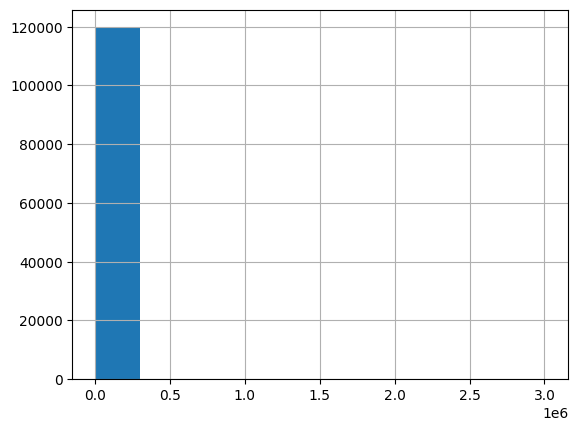

In [25]:
data['MonthlyIncome'].hist()

{'whiskers': [<matplotlib.lines.Line2D at 0x7f2a121710c0>,
 'caps': [<matplotlib.lines.Line2D at 0x7f2a12171600>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f2a1213f730>],
 'medians': [<matplotlib.lines.Line2D at 0x7f2a12171b40>],
 'fliers': [<matplotlib.lines.Line2D at 0x7f2a12171060>],
 'means': []}

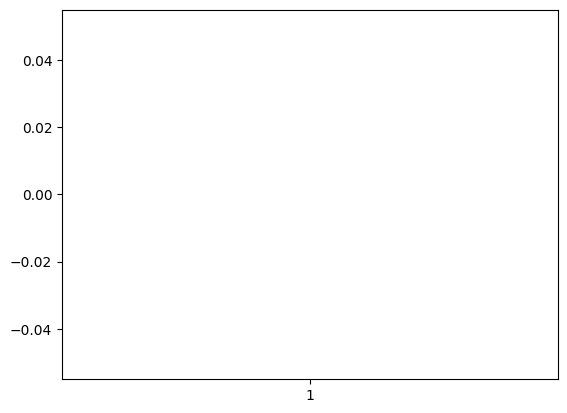

In [175]:
plt.boxplot(data.MonthlyIncome)

In [77]:
data.describe()

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfDependents,RealEstateLoansOrLines
count,148552.000000,148552.000000,148552.000000,148552.000000,148552.000000,1.198420e+05,148552.000000,148552.000000,148552.000000
mean,0.067189,6.103981,54.192559,0.391015,355.843722,6.679146e+03,8.503110,0.744278,1.077650
std,0.250349,250.969022,15.111694,3.805092,2046.610137,1.440730e+04,5.132986,1.110060,0.307422
min,0.000000,0.000000,21.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,1.000000
25%,0.000000,0.030629,43.000000,0.000000,0.179362,3.400000e+03,5.000000,0.000000,1.000000
50%,0.000000,0.155488,54.000000,0.000000,0.368980,5.400000e+03,8.000000,0.000000,1.000000
75%,0.000000,0.556871,67.000000,0.000000,0.874328,8.250000e+03,11.000000,1.000000,1.000000
max,1.000000,50708.000000,89.000000,98.000000,329664.000000,3.008750e+06,58.000000,20.000000,5.000000


In [168]:
median = data['MonthlyIncome'].median()

print(median)

data['MonthlyIncome'].fillna(median, inplace=True)

5400.0


In [45]:
data.isna().sum()

SeriousDlqin2yrs                            0
RevolvingUtilizationOfUnsecuredLines        0
age                                         0
NumberOfTime30-59DaysPastDueNotWorse        0
DebtRatio                                   0
MonthlyIncome                           28923
NumberOfOpenCreditLinesAndLoans             0
NumberOfDependents                          0
RealEstateLoansOrLines                      0
dtype: int64

In [ ]:
data.GroupAge.value_counts(age=null)

NameError: ignored

## Вопрос для Quiz

Чему равна медиана в столбце totaleveminutes? Ответ округлите до целого числа.

## Ошибочные значения

Выведите на экран число различных значений в столбце voicemailplan, используя value_counts

In [23]:
data['SeriousDlqin2yrs'].value_counts()

0    138777
1      9995
Name: SeriousDlqin2yrs, dtype: int64

## Вопрос для Quiz

Сколько строк содержат ошибочное значение в столбце voicemailplan?

In [ ]:
data['voicemailplan'] = data['voicemailplan'].replace('Nou', 'No')

In [ ]:
data['voicemailplan'].value_counts()

No     2421
Yes     912
Name: voicemailplan, dtype: int64

In [ ]:
# data['is_date'] = data['date'].apply(lambda x: 1 if x.isna() else 0)

## Основные числовые характеристики

Есть сильный дисбаланс классов!

In [ ]:
data['churn'].value_counts(normalize=True)

False    0.855086
True     0.144914
Name: churn, dtype: float64

In [230]:
data.describe()

,SeriousDlqin2yrs,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfDependents,RealEstateLoansOrLines
count,148552.000000,148552.000000,148552.000000,148552.000000,1.485520e+05,148552.000000,148552.000000,148552.000000
mean,0.067189,54.192559,0.391015,355.843722,6.431931e+03,8.503110,0.744278,1.077650
std,0.250349,15.111694,3.805092,2046.610137,1.295024e+04,5.132986,1.110060,0.307422
min,0.000000,21.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,1.000000
25%,0.000000,43.000000,0.000000,0.179362,3.900000e+03,5.000000,0.000000,1.000000
50%,0.000000,54.000000,0.000000,0.368980,5.400000e+03,8.000000,0.000000,1.000000
75%,0.000000,67.000000,0.000000,0.874328,7.417000e+03,11.000000,1.000000,1.000000
max,1.000000,89.000000,98.000000,329664.000000,3.008750e+06,58.000000,20.000000,5.000000


<Axes: >

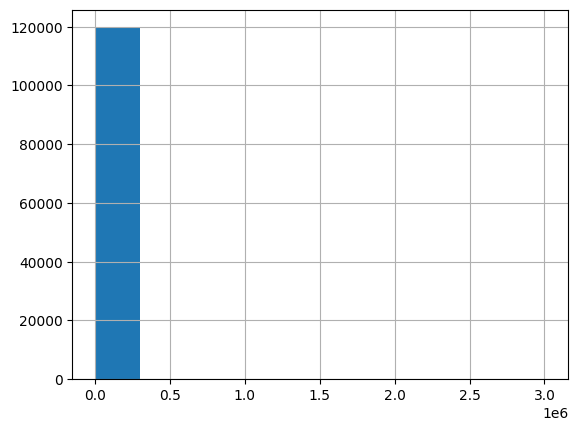

In [170]:
data['MonthlyIncome'].hist()

In [54]:
data.describe(include='object') # категориальные колонки

,RealEstateLoansOrLines
count,148552
unique,5
top,A
freq,138603


In [268]:
corr = data.corr() # строим матрицу корреляций

corr.style.background_gradient(cmap='coolwarm')

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfDependents,RealEstateLoansOrLines
SeriousDlqin2yrs,1.000000,-0.001840,-0.099963,0.131837,-0.008103,-0.017414,-0.031444,0.046202,0.027463
RevolvingUtilizationOfUnsecuredLines,-0.001840,1.000000,-0.002420,-0.001296,0.003932,0.006491,-0.011583,0.001054,-0.000931
age,-0.099963,-0.002420,1.000000,-0.045325,0.020859,0.023140,0.137310,-0.186082,0.018291
NumberOfTime30-59DaysPastDueNotWorse,0.131837,-0.001296,-0.045325,1.000000,-0.005882,-0.008452,-0.048175,0.000217,-0.003374
DebtRatio,-0.008103,0.003932,0.020859,-0.005882,1.000000,-0.018146,0.048193,-0.045480,0.086175
MonthlyIncome,-0.017414,0.006491,0.023140,-0.008452,-0.018146,1.000000,0.086351,0.065782,0.083873
NumberOfOpenCreditLinesAndLoans,-0.031444,-0.011583,0.137310,-0.048175,0.048193,0.086351,1.000000,0.068286,0.262467
NumberOfDependents,0.046202,0.001054,-0.186082,0.000217,-0.045480,0.065782,0.068286,1.000000,0.048285
RealEstateLoansOrLines,0.027463,-0.000931,0.018291,-0.003374,0.086175,0.083873,0.262467,0.048285,1.000000


Очень большая корреляция между сроками просрочки. Необходимо удалить 2 лишних + признак возрастной группы

In [28]:
data = data.drop(['NumberOfTimes90DaysLate','NumberOfTime60-89DaysPastDueNotWorse','GroupAge'],axis=1)

In [84]:
for col in data.columns:
    try:
        print(col, np.corrcoef(data[col], data['SeriousDlqin2yrs'])[0][1])
    except:
        pass

SeriousDlqin2yrs 1.0
RevolvingUtilizationOfUnsecuredLines -0.0018397478133073029
age -0.09996283754325004
NumberOfTime30-59DaysPastDueNotWorse 0.13183726418311048
DebtRatio -0.008102681421069586
MonthlyIncome -0.01741366262864136
NumberOfOpenCreditLinesAndLoans -0.031444399334181
NumberOfDependents 0.04620238056686157
RealEstateLoansOrLines 0.02746278159668276


<Axes: >

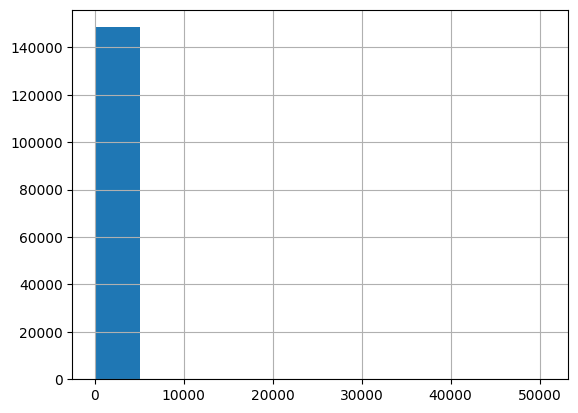

In [79]:
data['RevolvingUtilizationOfUnsecuredLines'].hist()

## Вопрос для Quiz

Какой признак имеет наибольшую корреляцию с целевой переменной (churn)?

## Визуализация данных

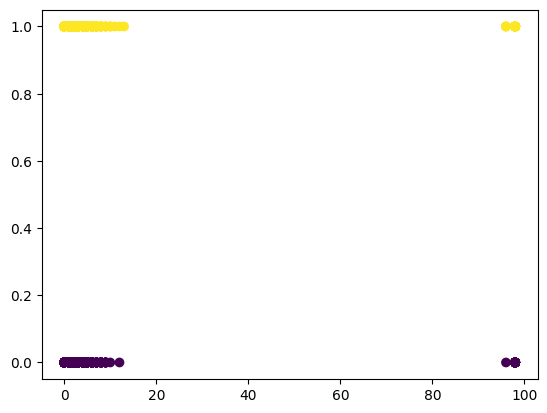

In [30]:
import matplotlib.pyplot as plt

plt.scatter(data['NumberOfTime30-59DaysPastDueNotWorse'], data['SeriousDlqin2yrs'], c=data['SeriousDlqin2yrs'])

<Axes: >

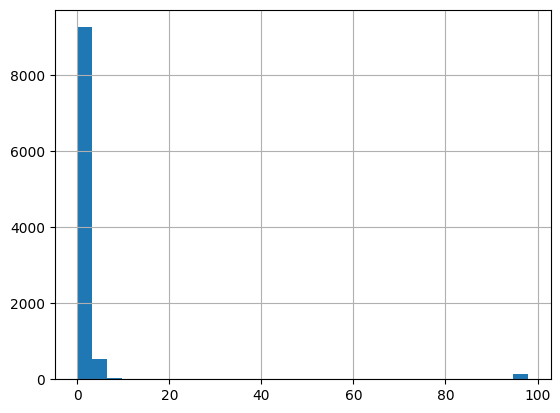

In [57]:
data[data.SeriousDlqin2yrs == 1]['NumberOfTime30-59DaysPastDueNotWorse'].hist(bins=30)

In [31]:
data.groupby('SeriousDlqin2yrs')['NumberOfTime30-59DaysPastDueNotWorse'].mean()

SeriousDlqin2yrs
0    0.260252
1    2.296248
Name: NumberOfTime30-59DaysPastDueNotWorse, dtype: float64

In [ ]:
У клиентов с просрочкой 90+ дней за последние 2 года уже было в среднем 2 просрочки по 30-59 дней.

Постройте диаграмму рассеяния для оценки влияния признака customerservicecalls на целевую переменную churn.

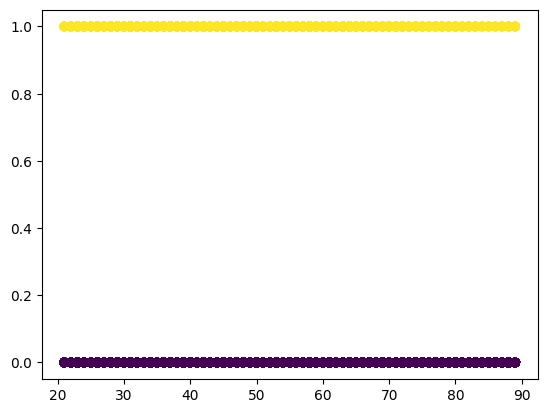

In [33]:
# your code here

plt.scatter(data['age'], data['SeriousDlqin2yrs'], c=data['SeriousDlqin2yrs'])

In [34]:
data.groupby('SeriousDlqin2yrs')['age'].mean()

SeriousDlqin2yrs
0    54.601814
1    48.550175
Name: age, dtype: float64

<Axes: >

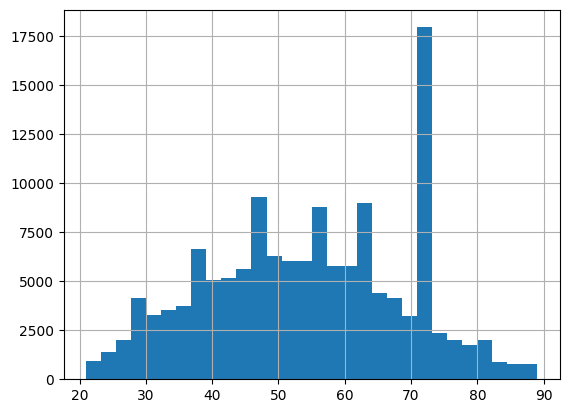

In [41]:
data[data.SeriousDlqin2yrs == 0]['age'].hist(bins=30)

<Axes: >

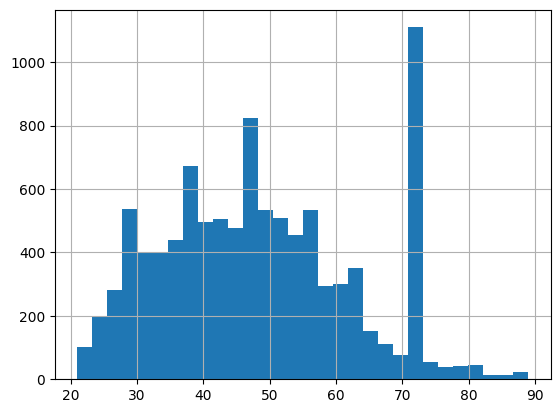

In [42]:
data[data.SeriousDlqin2yrs == 1]['age'].hist(bins=30)

Посчитайте среднее значение customerservicecalls для оттоковых и не оттоковых клиентов, используйте groupby.

In [ ]:
# your code here

data.groupby('churn')['customerservicecalls'].mean()

churn
False    1.449825
True     2.229814
Name: customerservicecalls, dtype: float64

## <font color='green'>2.1. Обучение модели</font>



Сформируем матрицу X объект-признак и вектор y целевой переменной.

In [252]:
X = data.drop('SeriousDlqin2yrs', axis=1) # матрица объект-признак
y = data['SeriousDlqin2yrs'] # целевая переменная

Давайте применим логистическую регрессию для поиска клиентов с просрочками 90+



Разобъём данные на train и test (test — 25% от всех данных). Зачем это делается?

In [253]:
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.25, random_state=42)

Для линейных моделей очень важно масштабирование признаков. У нас часть данных представлена десятками, а часть тысячами и тд, это негативно влияет на модель. Для привидения к одному масштабу используем StandardScaler, обучив метод на тренировочных данных и применив его и к трейну, и к тесту.

In [254]:
import pandas as pd
from sklearn.preprocessing import StandardScaler

ss = StandardScaler()
ss.fit(Xtrain)

Xtrain = pd.DataFrame(ss.transform(Xtrain), columns=X.columns)
Xtest = pd.DataFrame(ss.transform(Xtest), columns=X.columns)

Xtrain.head()

,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfDependents,RealEstateLoansOrLines
0,-0.020934,-0.409864,-0.104034,1.643187,-0.078565,0.678886,0.229922,-0.254272
1,-0.023415,1.244657,-0.104034,-0.179131,0.322353,-0.098593,-0.669124,-0.254272
2,-0.020024,-0.740768,0.168083,-0.179193,-0.303156,-1.459180,2.028014,-0.254272
3,-0.023703,1.840284,-0.104034,-0.179064,-0.162449,1.845103,-0.669124,-0.254272
4,-0.020687,-0.012779,-0.104034,-0.178829,-0.249649,0.290146,-0.669124,2.974528


Обучим логистическую регрессию на train и сделаем предсказание на новых для нее данных (test).

In [255]:
from sklearn.linear_model import LogisticRegression # линейная модель для задачи классификации

model = LogisticRegression() # объявление модели

model.fit(Xtrain, ytrain) # обучение модели

LogisticRegression()

In [256]:
pred_test = model.predict(Xtest) # предсказание классов

In [257]:
accuracy_score(ytest, pred_test) #доля верных ответов на тестовой выборке

0.9324950185793527

## Вопрос для Quiz

Доля верно определенных классов высокая! Значит ли это, что качество хорошее?


Проверим, сбалансирована ли выборка.

In [258]:
y.value_counts()

0    138571
1      9981
Name: SeriousDlqin2yrs, dtype: int64

Баланса классов нет: большинство клиентов не имеют просрочек ($y=0$). Если я "в лоб" проставлю всем константу 0, то угадаю 138571 из 148552 (это как раз 93,3%).

Посмотрим, что предсказывает модель.

In [94]:
pred_test[:20]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

## <font color='green'>2.2. Валидация модели</font>

Для оценки качества модели используются различные метрики качества. Давайте посмотрим, какие метрики полезно считать в задаче классификации, кроме accuracy.


In [259]:
from sklearn.metrics import confusion_matrix

confusion_matrix(ytest, pred_test)

array([[34590,    25],
       [ 2482,    41]])

In [260]:
ytest.value_counts()

0    34615
1     2523
Name: SeriousDlqin2yrs, dtype: int64

Модель верно определила очень мало оттоковых клиентов :(

<font color='blue'>Также можно посмотреть на метрику **recall (полнота)** - она показывает, какую долю клиентов с просрочками 90+ дней (объектов положительного класса) определила модель.(TN/(FN+TN))</font>

In [262]:
from sklearn.metrics import recall_score

recall_score(ytest, pred_test)

0.016250495441934205

Пропустили 98,4% клиентов, которые с просрочками 90+ дней

In [265]:
from sklearn.metrics import precision_score #точность. Из определенных, как "имеют просрочки 90+" сколько действительно имеют её(TN/(FP+TN)

precision_score(ytest, pred_test)

0.6212121212121212

In [187]:
#2 вариант: убиваем MonthlyIncome с большими суммами
data = pd.read_csv("credit_scoring_output.csv")
data = data[data.MonthlyIncome < 200000]
data.shape


(148523, 9)

In [232]:
#3 вариант: убиваем RealEstateLoansOrLines -Закодированное количество кредиов
data = pd.read_csv("credit_scoring_output.csv")
data = data.drop(['RealEstateLoansOrLines'], axis=1)
data.describe()

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfDependents
count,148552.000000,148552.000000,148552.000000,148552.000000,148552.000000,1.485520e+05,148552.000000,148552.000000
mean,0.067189,6.103981,54.192559,0.391015,355.843722,6.431931e+03,8.503110,0.744278
std,0.250349,250.969022,15.111694,3.805092,2046.610137,1.295024e+04,5.132986,1.110060
min,0.000000,0.000000,21.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000
25%,0.000000,0.030629,43.000000,0.000000,0.179362,3.900000e+03,5.000000,0.000000
50%,0.000000,0.155488,54.000000,0.000000,0.368980,5.400000e+03,8.000000,0.000000
75%,0.000000,0.556871,67.000000,0.000000,0.874328,7.417000e+03,11.000000,1.000000
max,1.000000,50708.000000,89.000000,98.000000,329664.000000,3.008750e+06,58.000000,20.000000


In [231]:
#4 вариант: убиваем RevolvingUtilizationOfUnsecuredLines - Общий баланс средств
data = pd.read_csv("credit_scoring_output.csv")
data = data.drop(['RevolvingUtilizationOfUnsecuredLines'], axis=1)
data.describe()

,SeriousDlqin2yrs,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfDependents,RealEstateLoansOrLines
count,148552.000000,148552.000000,148552.000000,148552.000000,1.485520e+05,148552.000000,148552.000000,148552.000000
mean,0.067189,54.192559,0.391015,355.843722,6.431931e+03,8.503110,0.744278,1.077650
std,0.250349,15.111694,3.805092,2046.610137,1.295024e+04,5.132986,1.110060,0.307422
min,0.000000,21.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,1.000000
25%,0.000000,43.000000,0.000000,0.179362,3.900000e+03,5.000000,0.000000,1.000000
50%,0.000000,54.000000,0.000000,0.368980,5.400000e+03,8.000000,0.000000,1.000000
75%,0.000000,67.000000,0.000000,0.874328,7.417000e+03,11.000000,1.000000,1.000000
max,1.000000,89.000000,98.000000,329664.000000,3.008750e+06,58.000000,20.000000,5.000000


In [233]:
#5 вариант: убиваем RevolvingUtilizationOfUnsecuredLines - Общий баланс средств
data = pd.read_csv("credit_scoring_output.csv")
data = data.drop(['RevolvingUtilizationOfUnsecuredLines'], axis=1)
data = data[data.MonthlyIncome < 200000]
data.describe()

,SeriousDlqin2yrs,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfDependents,RealEstateLoansOrLines
count,148523.000000,148523.000000,148523.000000,148523.000000,148523.000000,148523.000000,148523.000000,148523.000000
mean,0.067188,54.192435,0.391017,355.913199,6314.640170,8.502697,0.744201,1.077604
std,0.250349,15.112498,3.805445,2046.803895,5291.105043,5.132822,1.110023,0.307257
min,0.000000,21.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,0.000000,43.000000,0.000000,0.179468,3900.000000,5.000000,0.000000,1.000000
50%,0.000000,54.000000,0.000000,0.369063,5400.000000,8.000000,0.000000,1.000000
75%,0.000000,67.000000,0.000000,0.874585,7416.000000,11.000000,1.000000,1.000000
max,1.000000,89.000000,98.000000,329664.000000,184903.000000,58.000000,20.000000,5.000000


In [241]:
#3 вариант: убиваем RealEstateLoansOrLines -Закодированное количество кредиов
data = pd.read_csv("credit_scoring_output.csv")
data = data.drop(['age'], axis=1)
data.describe()

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfDependents,RealEstateLoansOrLines
count,148552.000000,148552.000000,148552.000000,148552.000000,1.485520e+05,148552.000000,148552.000000,148552.000000
mean,0.067189,6.103981,0.391015,355.843722,6.431931e+03,8.503110,0.744278,1.077650
std,0.250349,250.969022,3.805092,2046.610137,1.295024e+04,5.132986,1.110060,0.307422
min,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,1.000000
25%,0.000000,0.030629,0.000000,0.179362,3.900000e+03,5.000000,0.000000,1.000000
50%,0.000000,0.155488,0.000000,0.368980,5.400000e+03,8.000000,0.000000,1.000000
75%,0.000000,0.556871,0.000000,0.874328,7.417000e+03,11.000000,1.000000,1.000000
max,1.000000,50708.000000,98.000000,329664.000000,3.008750e+06,58.000000,20.000000,5.000000


В данном случае для нас важнее recall, тк мы выдадим много невозвратных кредитов, что повлечет потери банка.
Либо precision_score, тк банк зарабатывает на кредитах и любой отказ это упущенная выгода, а просрочки мы будем в судебном порядке взымать.

В любом случае recall слишком мал и с этим нужно разбираться. Посмотрим на вероятности, выдаваемые моделью.

In [183]:
probs = model.predict_proba(Xtest)

probs[:10]

array([[0.96407927, 0.03592073],
       [0.86116811, 0.13883189],
       [0.92342932, 0.07657068],
       [0.96124756, 0.03875244],
       [0.94256992, 0.05743008],
       [0.94075923, 0.05924077],
       [0.9187528 , 0.0812472 ],
       [0.90350756, 0.09649244],
       [0.90435003, 0.09564997],
       [0.90109214, 0.09890786]])

Модель слишком позитивна. Она присваивает классу 0 (клиент не имеет просрочек 90+) всегда большие вероятности. 

<font color='blue'>Попробуем изменить **порог для перевода вероятности в классы** со стандартного 0.5 на порог поменьше.</blue>

In [159]:
probs_arrears = probs[:,1]

classes = probs_arrears > 0.2

In [161]:
confusion_matrix(ytest, classes)

array([[34558,    57],
       [ 2466,    57]])

In [152]:
ytest.value_counts()

0    34615
1     2523
Name: SeriousDlqin2yrs, dtype: int64

In [153]:
recall_score(ytest, classes)

0.2845818470075307

In [160]:
from sklearn.metrics import precision_score #точность. Из определенных, как "имеют просрочки 90+" сколько действительно имеют её(TN/(FP+TN)

precision_score(ytest, classes)

0.5

Теперь модель стала находить оттоковых клиентов, но и больше ошибается на тех клиентах, которые не уйдут.

## <font color='green'>3. Интерпретация модели</font>

После обучения модели можно посмотреть на её веса, то есть на коэффициенты при признаках, найденные моделью.

In [266]:
model.coef_, model.intercept_

(array([[ 0.00067279, -0.34543796,  0.19354693, -0.0829788 , -0.60779576,
         -0.0587522 ,  0.14477694,  0.1768087 ]]),
 array([-2.75253082]))

In [267]:
import pandas as pd

coef_table = pd.DataFrame({'features' : list(X.columns), 'weights' : list(model.coef_[0])})

coef_table.sort_values(by='weights')

,features,weights
4,MonthlyIncome,-0.607796
1,age,-0.345438
3,DebtRatio,-0.082979
5,NumberOfOpenCreditLinesAndLoans,-0.058752
0,RevolvingUtilizationOfUnsecuredLines,0.000673
6,NumberOfDependents,0.144777
7,RealEstateLoansOrLines,0.176809
2,NumberOfTime30-59DaysPastDueNotWorse,0.193547


Если вес у признака положительный, то признак вносит положительный вклад в ответ, то есть чем больше значение признака, тем больше это дает вклад в положительный класс объекта и наоборот.

## Метод ближайших соседей (бонус)

Существует еще один простой метод для решения задач классификации - метод ближайших соседей.

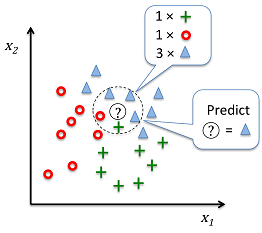

Попробуем применить метод ближайших соседей для решения поставленной задачи.

In [269]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier()

In [276]:
knn.fit(Xtrain, ytrain)

pred_test2 = knn.predict_proba(Xtest)[:,1]

classes2 = pred_test2 > 0.5

confusion_matrix(ytest, classes2)

array([[34233,   382],
       [ 2322,   201]])

## Вопрос для Quiz

Вычислите recall (долю найденных моделью оттоковых клиентов) при пороге 0.1. Ответ не округляйте.

In [274]:
# your code here
recall_score(ytest, classes2)

0.21046373365041618

In [275]:
from sklearn.metrics import precision_score #точность. Из определенных, как "имеют просрочки 90+" сколько действительно имеют её(TN/(FP+TN)

precision_score(ytest, classes2)

0.24092558983666063

## <font color='green'>4. Сохранение результатов экспериментов</font>

Что сохраняем?

* Предсказания модели
* Эксперименты
* Модель

Сначала сохраним предсказания модели в файл:

In [107]:
Xtest['predictions'] = probs_churn

Xtest[['predictions']].to_csv("PredictionsChurn.csv", index=False)

Теперь сохраним саму модель:

In [108]:
import pickle 

with open('model.pickle', 'wb') as f:
    pickle.dump(model, f)

# а так модель можно загрузить из файла:  
# with open('filename.pickle', 'rb') as f:
#     model = pickle.load(f)

Сохраним полученную модель, файл с предсказаниями и ноутбук с экспериментами на гитхаб.

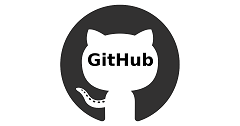

## <font color='green'>5. Градиентный бустинг</font>

Мы поработали с линейными моделями. Они весьма и весьма простые — предполагают независимость признаков и линейную связь между каждым признаком и целевой переменной. Конечно, в наших данных вряд ли всё так просто. Можно пытаться усложнять линейные модели: добавлять нелинейные признаки, переходить в новое признаковое пространство. Но это всё полумеры.

Сейчас мы поработаем с градиентным бустингом — одним из самых мощных подходов для работы с табличными данными.

Пока не ушли далеко — посчитаем и запомним качество логистической регрессии.

In [109]:
from sklearn import metrics

print("LR quality:")
print("precision: ", metrics.precision_score(ytest, classes))
print("recall: ", metrics.recall_score(ytest, classes))
print("auc-roc: ", metrics.roc_auc_score(ytest, probs[:, 1]))

LR quality:
precision:  0.5
recall:  0.022592152199762187
auc-roc:  0.6584134384863933


Есть много имплементаций градиентного бустинга. Мы будем пользоваться CatBoost — библиотекой от Яндекса, которая очень эффективно написана и широко используется в мире.

In [110]:
!pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.6/98.6 MB 2.3 MB/s eta 0:00:00


In [115]:
from catboost import CatBoostClassifier, Pool

In [116]:
train_set = Pool(Xtrain, ytrain)
test_set = Pool(Xtest, ytest)

In [122]:
gbm = CatBoostClassifier(iterations=100,
                          depth=2,
                          learning_rate=0.1,
                          loss_function='Logloss',
                          eval_metric='AUC',
                          verbose=False)
gbm.fit(train_set, eval_set=test_set)
gbm_preds = gbm.predict_proba(Xtest)

CatBoostError: ignored

In [123]:
eval_metrics = gbm.get_evals_result()
plt.plot(eval_metrics['validation']['AUC'])
plt.xlabel('n_trees')
plt.ylabel('AUC')
plt.grid()

KeyError: ignored

In [119]:
gbm_classes = (gbm_preds[:, 1] > 0.3)
print("precision: ", metrics.precision_score(ytest, gbm_classes))
print("recall: ", metrics.recall_score(ytest, gbm_classes))
print("auc-roc: ", metrics.roc_auc_score(ytest, gbm_preds[:, 1]))

NameError: ignored

In [120]:
coef_table = pd.DataFrame({'features' : list(X.columns), 'importances' : list(gbm.get_feature_importance())})

coef_table.sort_values(by='importances')

CatBoostError: ignored

## Вопрос для Quiz

Попробуйте обучить градиентный бустинг с другой длиной шага. Получится ли улучшить AUC-ROC на тесте?

In [ ]:
# ваш код здесь

## <font color='green'>6. Обработка категориальных признаков</font>

Выше мы удаляли все категориальные столбцы:

`X = X.drop(['state','areacode','voicemailplan','internationalplan'], axis=1)`

А вдруг там содержится много полезной информации? Попробуем её сохранить.

In [121]:
Xtrain, Xtest, ytrain, ytest = train_test_split(X_full, y, test_size=0.25, random_state=42)

NameError: ignored

In [ ]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

categorical = ['state','areacode','voicemailplan','internationalplan']
numeric_features = X.columns

column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown="ignore"), categorical),
    ('scaling', StandardScaler(), numeric_features)
])

X_transformed = column_transformer.fit_transform(Xtrain)
X_test_transformed = column_transformer.transform(Xtest)

In [ ]:
X_transformed.shape

(2499, 69)

In [ ]:
model = LogisticRegression()
model.fit(X_transformed, ytrain)
pred = model.predict_proba(X_test_transformed)

In [ ]:
classes = (pred[:, 1] > 0.5)
print("precision: ", metrics.precision_score(ytest, classes))
print("recall: ", metrics.recall_score(ytest, classes))
print("auc-roc: ", metrics.roc_auc_score(ytest, pred[:, 1]))

precision:  0.5681818181818182
recall:  0.2
auc-roc:  0.8343244005641749


In [ ]:
train_set = Pool(X_transformed, ytrain)
test_set = Pool(X_test_transformed, ytest)
gbm = CatBoostClassifier(iterations=100,
                          depth=2,
                          learning_rate=0.1,
                          loss_function='Logloss',
                          eval_metric='AUC',
                          verbose=False)
gbm.fit(train_set, eval_set=test_set)
gbm_preds = gbm.predict_proba(test_set)
gbm_classes = (gbm_preds[:, 1] > 0.3)
print("precision: ", metrics.precision_score(ytest, gbm_classes))
print("recall: ", metrics.recall_score(ytest, gbm_classes))
print("auc-roc: ", metrics.roc_auc_score(ytest, gbm_preds[:, 1]))

precision:  0.8495575221238938
recall:  0.768
auc-roc:  0.9301156558533146
